# Hacker News Dataset EDA


Tags: python, machine-learning

date: 2022-06-21T21:00:00+10:00

feature_image: /images/hackernews_eda.png
  
<!--eofm-->


> A mystery! A riddle! A puzzle! A quest! This was the moment that Ada loved best.
>
> *Ada Twist, Scientist*, Andrea Beaty

This is an exploration of 2021 [Hacker News](https://news.ycombinator.com/) posts as a precursor to [building a books dataset](https://skeptric.com/book-title-ner-outline/).

The data was sourced from the Google Bigquery public dataset `bigquery-public-data.hacker_news.full` using a [Kaggle notebook](https://www.kaggle.com/code/edwardjross/hackernews-2021-export/notebook).

```
SELECT *
FROM `bigquery-public-data.hacker_news.full`
where '2021-01-01' <= timestamp and timestamp < '2022-01-01'
```

I want to get a basic understanding of what's in the dataset before doing any data mining.

The [Hacker News FAQ](https://news.ycombinator.com/newsfaq.html) is useful for contextualising some of the fields.

This post was generated with a [Jupyter notebook](/notebooks/hackernews-dataset-eda.ipynb).

Please note that these comments may contain some explicit content.

# Load in data

In [1]:
import numpy as np
import pandas as pd

import html

from pathlib import Path

In [2]:
pd.options.display.max_columns = 100

Download [the data](https://www.kaggle.com/code/edwardjross/hackernews-2021-export/data) into this path first.

Make sure we use nullable dtypes to avoid converting integer identifier to floats, and set the unique `id` as the key.

In [3]:
hn_path = Path('../data/hackernews2021.parquet')

df = pd.read_parquet(hn_path, use_nullable_dtypes=True).set_index('id')

In [4]:
assert df.index.is_unique

In [5]:
assert df.index.notna().all()

# Summary

Here's the schema described in Big Query

| name        | type      | description                                                           |
|-------------|-----------|-----------------------------------------------------------------------|
| title       | STRING    | Story title                                                           |
| url         | STRING    | Story url                                                             |
| text        | STRING    | Story or comment text                                                 |
| dead        | BOOLEAN   | Is dead?                                                              |
| by          | STRING    | The username of the item's author.                                    |
| score       | INTEGER   | Story score                                                           |
| time        | INTEGER   | Unix time                                                             |
| timestamp   | TIMESTAMP | Timestamp for the unix time                                           |
| type        | STRING    | Type of details (comment, comment_ranking, poll, story, job, pollopt) |
| id          | INTEGER   | The item's unique id.                                                 |
| parent      | INTEGER   | Parent comment ID                                                     |
| descendants | INTEGER   | Number of story or poll descendants                                   |
| ranking     | INTEGER   | Comment ranking                                                       |
| deleted     | BOOLEAN   | Is deleted?                                                           |


In [6]:
df.dtypes

title                       string
url                         string
text                        string
dead                       boolean
by                          string
score                        Int64
time                         Int64
timestamp      datetime64[ns, UTC]
type                        string
parent                       Int64
descendants                  Int64
ranking                      Int64
deleted                    boolean
dtype: object

Here's a sample of the dataframe.

Note that we can view any individual item by appending the `id` in the URL `https://news.ycombinator.com/item?id=`

In [7]:
df

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,
27405131,<NA>,<NA>,They didn&#x27;t say they <i>weren&#x27;t</i> ...,<NA>,chrisseaton,<NA>,1622901869,2021-06-05 14:04:29+00:00,comment,27405089,<NA>,<NA>,<NA>
27814313,<NA>,<NA>,"Check out <a href=""https:&#x2F;&#x2F;www.remno...",<NA>,noyesno,<NA>,1626119705,2021-07-12 19:55:05+00:00,comment,27812726,<NA>,<NA>,<NA>
28626089,<NA>,<NA>,Like a million-dollars pixel but with letters....,<NA>,alainchabat,<NA>,1632381114,2021-09-23 07:11:54+00:00,comment,28626017,<NA>,<NA>,<NA>
27143346,<NA>,<NA>,Not the question...,<NA>,SigmundA,<NA>,1620920426,2021-05-13 15:40:26+00:00,comment,27143231,<NA>,<NA>,<NA>
29053108,<NA>,<NA>,There’s the Unorganized Militia of the United ...,<NA>,User23,<NA>,1635636573,2021-10-30 23:29:33+00:00,comment,29052087,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27367848,<NA>,<NA>,Housing supply isn’t something that can’t chan...,<NA>,JCM9,<NA>,1622636746,2021-06-02 12:25:46+00:00,comment,27367172,<NA>,<NA>,<NA>
28052800,<NA>,<NA>,Final Fantasy XIV has been experiencing consta...,<NA>,amyjess,<NA>,1628017217,2021-08-03 19:00:17+00:00,comment,28050798,<NA>,<NA>,<NA>
28052805,<NA>,<NA>,How did you resolve it?,<NA>,8ytecoder,<NA>,1628017238,2021-08-03 19:00:38+00:00,comment,28049375,<NA>,<NA>,<NA>


Every post has a time, timestamp and parent.

No post has a ranking.

In [8]:
df.notna().mean().apply('{:0.2%}'.format)

title            8.97%
url              8.46%
text            88.57%
dead             3.87%
by              97.22%
score            9.04%
time           100.00%
timestamp      100.00%
type           100.00%
parent          90.64%
descendants      7.00%
ranking          0.00%
deleted          2.78%
dtype: object

We filtered to data in 2021, so it's all in this range

In [9]:
df['timestamp'].min(), df['timestamp'].max()

(Timestamp('2021-01-01 00:00:01+0000', tz='UTC'),
 Timestamp('2021-12-31 23:59:50+0000', tz='UTC'))

Most threads consist of a `story` which have `comments`. Apparently there are also `job` and `poll` objects.

In [10]:
df['type'].value_counts()

comment    3766009
story       387194
job           1422
pollopt        385
poll            53
Name: type, dtype: Int64

# Date and Time

There's a spike in January (holidays?) a drop in February (lower days), but a fairly consistent amount of traffic.

<AxesSubplot:>

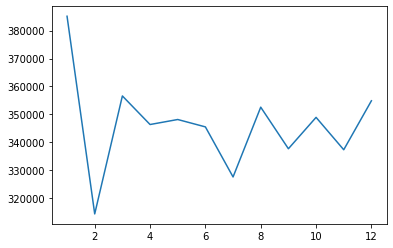

In [11]:
df['timestamp'].dt.month.value_counts().sort_index().plot()

Looking at the daily traffic it look like there may be weekly effects, but aside from a spike towards the end of January it's fairly consistent.

<AxesSubplot:>

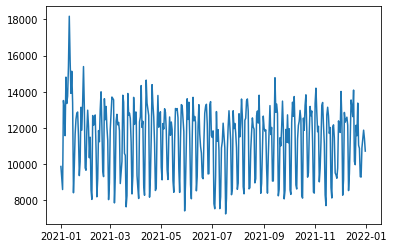

In [12]:
df['timestamp'].dt.date.value_counts().sort_index().plot()

Most posts are made on the weekdays

In [13]:
df['timestamp'].dt.day_name().value_counts()

Tuesday      662106
Wednesday    658830
Thursday     654405
Monday       628152
Friday       625707
Sunday       467553
Saturday     458310
Name: timestamp, dtype: int64

Based on the [4am rule](https://skeptric.com/4am-rule/) is looks like the most common timezone is around UTC-1.

This is slightly surprising, I would expect it could be closer to a US timezone (around -4 to -8). Maybe there's more posting from other regions than I'd have thought.

<AxesSubplot:>

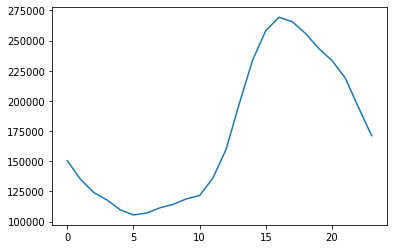

In [14]:
df['timestamp'].dt.hour.value_counts().sort_index().plot()

# Story

A story consists of a `title`, and it looks like either a `url` or `text`

In [15]:
story = df.query('type=="story"')
story

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,
28540306,CoinCircle for Life,<NA>,"Hello, Lets join us to CoinCircle for our bett...",True,rend-airdrop,1,1631719412,2021-09-15 15:23:32+00:00,story,<NA>,<NA>,<NA>,<NA>
26273978,Find the number of third-party privacy tracker...,<NA>,Exodus Privacy is a non-profit organization th...,True,moulidorai,1,1614341393,2021-02-26 12:09:53+00:00,story,<NA>,<NA>,<NA>,<NA>
27214431,Ask HN: Desk Recommendations?,<NA>,I often see standing desk recommendations here...,True,throwaw9l938ni,1,1621458219,2021-05-19 21:03:39+00:00,story,<NA>,<NA>,<NA>,<NA>
25705820,Demand Hunter Biden Be Arrested,<NA>,"There are so many pictures of Hunter Biden, Jo...",True,bidenpedo,1,1610232470,2021-01-09 22:47:50+00:00,story,<NA>,<NA>,<NA>,<NA>
26110009,Deep learning multivariate nonlinear regression,<NA>,Does deep learning really work for regression ...,True,dl_regression,1,1613095333,2021-02-12 02:02:13+00:00,story,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28773509,Apple to face EU antitrust charge over NFC chip,https://www.reuters.com/technology/exclusive-e...,<NA>,<NA>,nojito,170,1633530062,2021-10-06 14:21:02+00:00,story,<NA>,219,<NA>,<NA>
26400239,The Roblox Microverse,https://stratechery.com/2021/the-roblox-microv...,<NA>,<NA>,Kinrany,173,1615306495,2021-03-09 16:14:55+00:00,story,<NA>,203,<NA>,<NA>
27559832,"Safari 15 on Mac OS, a user interface mess",https://morrick.me/archives/9368,<NA>,<NA>,freediver,463,1624104913,2021-06-19 12:15:13+00:00,story,<NA>,353,<NA>,<NA>


Stories normally have title and a URL, and occasionally have text.

They're almost always `by` someone, and have a `score`.
They never have a `parent` (they're always top level), but they normally have `descendants`.

Some are dead (removed by Hacker News) and some are deleted (removed by the author).

In [16]:
(
    story
    .notna()
    .mean()
    .apply('{:0.1%}'.format)
)

title           95.9%
url             90.5%
text             4.9%
dead            22.5%
by              96.6%
score           96.6%
time           100.0%
timestamp      100.0%
type           100.0%
parent           0.0%
descendants     75.1%
ranking          0.0%
deleted          3.4%
dtype: object

By seems to be missing only for deleted stories

In [17]:
(
    story
    .query('by.isna()')
)

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,
26779931,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1618238390,2021-04-12 14:39:50+00:00,story,<NA>,<NA>,<NA>,True
26122158,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1613203434,2021-02-13 08:03:54+00:00,story,<NA>,<NA>,<NA>,True
25699401,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1610190538,2021-01-09 11:08:58+00:00,story,<NA>,<NA>,<NA>,True
26206857,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1613848074,2021-02-20 19:07:54+00:00,story,<NA>,<NA>,<NA>,True
26316571,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1614700390,2021-03-02 15:53:10+00:00,story,<NA>,<NA>,<NA>,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28201589,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1629140598,2021-08-16 19:03:18+00:00,story,<NA>,<NA>,<NA>,True
26786548,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1618271177,2021-04-12 23:46:17+00:00,story,<NA>,<NA>,<NA>,True
26689984,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1617548611,2021-04-04 15:03:31+00:00,story,<NA>,<NA>,<NA>,True


Every story has a `by` unless it's deleted or dead.

In [18]:
(
    story
    .query('by.isna() & deleted.isna() & dead.isna()')
)

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,


>  **How do I make a link in a text submission?**
>
> You can't. This is to prevent people from submitting a link with their comments in a privileged position at the top of the page. If you want to submit a link with comments, just submit it, then add a regular comment. 

This seems to be true most of the time

In [19]:
(
    story
    .assign(
        has_url = lambda _: ~_.url.isna(),
        has_text = lambda _: ~_.text.isna(),
        has_url_and_text = lambda _: _.has_url & _.has_text,
        has_url_or_text = lambda _: _.has_url | _.has_text,
    )
    .filter(like='has_')
    .mean()
)

has_url             0.904606
has_text            0.048536
has_url_and_text    0.000031
has_url_or_text     0.953111
dtype: float64

There seems to be a few exceptions for Show HN.

We actually don't have metadata to identify Ask HN and Show HN.

In [20]:
story.query('~url.isna() & ~text.isna()')

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,
28074827,Show HN: Visualizing a Codebase,https://octo.github.com/projects/repo-visualiz...,I explored an alternative way to view codebase...,<NA>,wattenberger,283,1628176192,2021-08-05 15:09:52+00:00,story,<NA>,96,<NA>,<NA>
29019925,Show HN: Guestio – A better way to find and bo...,https://guestio.com/,Guestio is an all-in-one tool designed to help...,<NA>,travischappelll,4,1635374411,2021-10-27 22:40:11+00:00,story,<NA>,2,<NA>,<NA>
26346586,Show HN: Practical Python Projects book release,https://practicalpython.yasoob.me,Hi everyone!<p>I just released the Practical P...,<NA>,yasoob,88,1614884336,2021-03-04 18:58:56+00:00,story,<NA>,14,<NA>,<NA>
27787426,Show HN: Homer – A tool to build interactive t...,https://usehomer.app,"Hi HN, my name is Rahul Sarathy and I built Ho...",<NA>,Outofthebot,62,1625858111,2021-07-09 19:15:11+00:00,story,<NA>,26,<NA>,<NA>
27684916,Why do we work so damn much?,https://www.nytimes.com/2021/06/29/opinion/ezr...,The New York Times: Opinion | Why Do We Work S...,<NA>,anirudhgarg,44,1625027907,2021-06-30 04:38:27+00:00,story,<NA>,62,<NA>,<NA>
27257586,C is not a serious programming language,https://www.yodaiken.com/2021/05/16/c-is-not-a...,&lt;https:&#x2F;&#x2F;www.yodaiken.com&#x2F;20...,True,vyodaiken,1,1621796527,2021-05-23 19:02:07+00:00,story,<NA>,<NA>,<NA>,<NA>
28934833,Bioelektryczność – Polish Robotics (1968) [video],https://www.youtube.com/watch?v=NjrYk546uBA,I&#x27;m curious what was the state of an art ...,<NA>,danielEM,134,1634757119,2021-10-20 19:11:59+00:00,story,<NA>,28,<NA>,<NA>
26998308,Show HN: Second-Chance Pool,https://news.ycombinator.com/pool,HN&#x27;s second-chance pool is a way to give ...,<NA>,dang,543,1619811719,2021-04-30 19:41:59+00:00,story,<NA>,91,<NA>,<NA>
29225588,Show HN: Grapic – Real whiteboards online usin...,https://www.grapic.co/,"Hi HN,<p>During the pandemic, two friends and ...",<NA>,nikonp,97,1636969643,2021-11-15 09:47:23+00:00,story,<NA>,24,<NA>,<NA>


The scores look like they follow a sort of power law.

<AxesSubplot:ylabel='Frequency'>

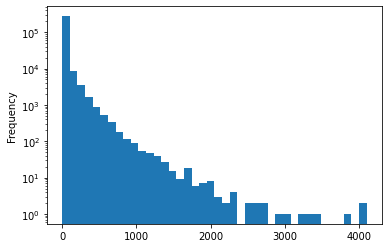

In [21]:
(
    story
    .query('dead.isna() & deleted.isna()')
    .score
    .fillna(0.)
    .plot
    .hist(logy=True, bins=40)
)

And descendants follow a similar path

<AxesSubplot:ylabel='Frequency'>

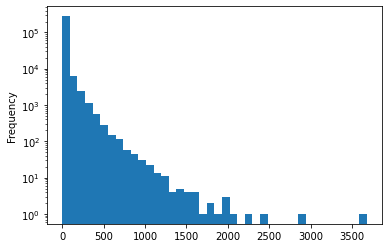

In [22]:
(
    story
    .query('dead.isna() & deleted.isna()')
    .descendants
    .fillna(0.)
    .plot
    .hist(logy=True, bins=40)
)

It looks like the titles must be below around 80 characters and are typically around 60

<AxesSubplot:ylabel='Frequency'>

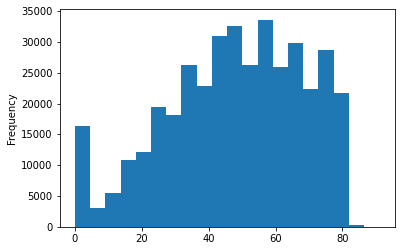

In [23]:
story.title.fillna('').str.len().plot.hist(bins=20)

The text can be much longer and follows a decaying distribution

<AxesSubplot:ylabel='Frequency'>

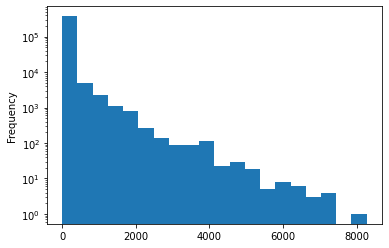

In [24]:
story.text.fillna('').str.len().plot.hist(bins=20, logy=True)

Some URLs can be *very* long (I guess they can have all sorts of query parameters)

<AxesSubplot:ylabel='Frequency'>

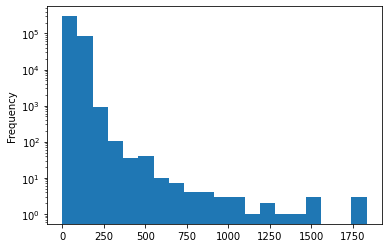

In [25]:
story.url.fillna('').str.len().plot.hist(bins=20, logy=True)

In [26]:
from urllib.parse import urlparse

Common hosts; Github, YouTube, twitter

In [27]:
story_url_host_counts = story['url'].dropna().map(lambda x: urlparse(x).hostname).value_counts()

story_url_host_counts.head(20)

github.com                13622
www.youtube.com           12843
twitter.com                6968
en.wikipedia.org           6218
www.nytimes.com            5647
medium.com                 4964
www.theguardian.com        4244
arstechnica.com            3545
www.bloomberg.com          3007
www.bbc.com                2996
www.theverge.com           2888
dev.to                     2746
www.wsj.com                2704
www.reuters.com            2445
techcrunch.com             1820
www.cnbc.com               1792
www.reddit.com             1430
www.bbc.co.uk              1426
www.washingtonpost.com     1413
www.theatlantic.com        1374
Name: url, dtype: int64

Again a small handful of hosts get most of the links

<AxesSubplot:ylabel='Frequency'>

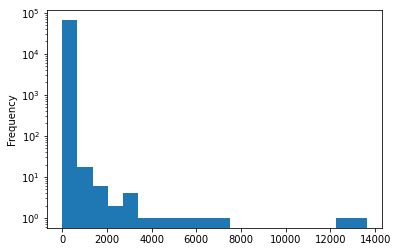

In [28]:
story_url_host_counts.plot.hist(logy=True, bins=20)

There are some power users that post a *lot* of stories

In [29]:
story_by_counts = story.by.value_counts()

story_by_counts.head(20)

Tomte              4856
todsacerdoti       3031
tosh               2940
pseudolus          2876
rbanffy            2875
mooreds            1915
samizdis           1834
giuliomagnifico    1570
feross             1491
CapitalistCartr    1413
ingve              1399
fortran77          1358
gmays              1162
infodocket         1098
belter             1078
graderjs           1061
elsewhen           1053
kiyanwang          1009
1cvmask            1005
LinuxBender         996
Name: by, dtype: Int64

And again a fast decline

<AxesSubplot:ylabel='Frequency'>

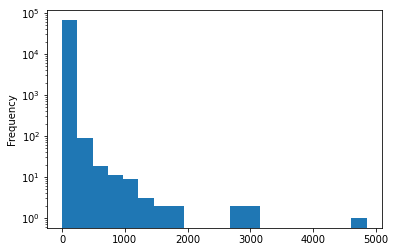

In [30]:
story_by_counts.plot.hist(logy=True, bins=20)

# Comments

In [31]:
comments = df.query('type == "comment"')
comments

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted
id,,,,,,,,,,,,,
27405131,<NA>,<NA>,They didn&#x27;t say they <i>weren&#x27;t</i> ...,<NA>,chrisseaton,<NA>,1622901869,2021-06-05 14:04:29+00:00,comment,27405089,<NA>,<NA>,<NA>
27814313,<NA>,<NA>,"Check out <a href=""https:&#x2F;&#x2F;www.remno...",<NA>,noyesno,<NA>,1626119705,2021-07-12 19:55:05+00:00,comment,27812726,<NA>,<NA>,<NA>
28626089,<NA>,<NA>,Like a million-dollars pixel but with letters....,<NA>,alainchabat,<NA>,1632381114,2021-09-23 07:11:54+00:00,comment,28626017,<NA>,<NA>,<NA>
27143346,<NA>,<NA>,Not the question...,<NA>,SigmundA,<NA>,1620920426,2021-05-13 15:40:26+00:00,comment,27143231,<NA>,<NA>,<NA>
29053108,<NA>,<NA>,There’s the Unorganized Militia of the United ...,<NA>,User23,<NA>,1635636573,2021-10-30 23:29:33+00:00,comment,29052087,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27367848,<NA>,<NA>,Housing supply isn’t something that can’t chan...,<NA>,JCM9,<NA>,1622636746,2021-06-02 12:25:46+00:00,comment,27367172,<NA>,<NA>,<NA>
28052800,<NA>,<NA>,Final Fantasy XIV has been experiencing consta...,<NA>,amyjess,<NA>,1628017217,2021-08-03 19:00:17+00:00,comment,28050798,<NA>,<NA>,<NA>
28052805,<NA>,<NA>,How did you resolve it?,<NA>,8ytecoder,<NA>,1628017238,2021-08-03 19:00:38+00:00,comment,28049375,<NA>,<NA>,<NA>


Comments can't have a tile or a URL.

They almost always have a `text` and a `by` (I'd guess it's missing for deleted and dead threads).

We don't ever get a `score` or `ranking` or `descendants` even though these things may make sense.

In [32]:
(
    comments
    .notna()
    .mean()
    .apply('{:0.1%}'.format)
)

title            0.0%
url              0.0%
text            97.2%
dead             2.0%
by              97.3%
score            0.0%
time           100.0%
timestamp      100.0%
type           100.0%
parent         100.0%
descendants      0.0%
ranking          0.0%
deleted          2.7%
dtype: object

# Parents

We can look at the type of the parent's comments (they'll sometimes be missing if the parent was posted before our cutoff date.

Most comments parent is another comment in a thread.

In [33]:
(
    comments
    .merge(df['type'], how='left', left_on='parent', right_index=True, suffixes=('', '_parent'), validate='m:1')
    ['type_parent']
    .value_counts(dropna=False)
)

comment    2997792
story       765342
<NA>          2412
poll           463
Name: type_parent, dtype: Int64

We can efficiently look up a parent using a dictionary, returning `<NA>` when it's not there.

In [34]:
from collections import defaultdict

parent_dict = df['parent'].dropna().to_dict()

parent_dict = defaultdict(lambda: pd.NA, parent_dict)


In [35]:
%%time
df['parent'].map(parent_dict, na_action='ignore')

CPU times: user 2.4 s, sys: 28.1 ms, total: 2.43 s
Wall time: 2.43 s


id
27405131    27405024
27814313    27807850
28626089    28625485
27143346    27142955
29053108    29052012
              ...   
27367848        <NA>
28052800    28049873
28052805    28046997
26704924    26704392
27076885    27074332
Name: parent, Length: 4155063, dtype: object

We can do this iteratively to find all the parents.

When there is no parent we'll return `<NA>`; this particular way of doing it gets faster the fewer non-null elements there are.

In [36]:
from tqdm.notebook import tqdm

MAX_DEPTH = 50

df['parent0'] = df['parent']

for idx in tqdm(range(MAX_DEPTH)):
    last_col = f'parent{idx}'
    col = f'parent{idx+1}'
    
    df[col] = df[last_col].map(parent_dict, na_action='ignore')
    if df[col].isna().all():
        del df[col]
        break
    

  0%|          | 0/50 [00:00<?, ?it/s]

We can now see all the parents of any element

In [37]:
df.filter(regex='parent\d+')

,parent0,parent1,parent2,parent3,parent4,parent5,parent6,parent7,parent8,parent9,parent10,parent11,parent12,parent13,parent14,parent15,parent16,parent17,parent18,parent19,parent20,parent21,parent22,parent23,parent24,parent25,parent26,parent27,parent28,parent29,parent30,parent31,parent32,parent33,parent34,parent35,parent36,parent37,parent38,parent39,parent40,parent41,parent42,parent43
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
27405131,27405089,27405024,27404902,27404548,27404512,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
27814313,27812726,27807850,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
28626089,28626017,28625485,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
27143346,27143231,27142955,27142884,27142567,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
29053108,29052087,29052012,29051947,29051758,29051607,29051478,29051448,29051365,29051109,29043296,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27367848,27367172,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
28052800,28050798,28049873,28049688,28049620,28049359,28048919,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
28052805,28049375,28046997,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


One useful concept is the *root*, the parent that has no parents itself (generally because it's top level, but sometimes because the parent isn't in the dataframe).

In [38]:
%%time
root = None

for col in df.filter(regex='parent\d+').iloc[:,::-1]:
    if root is None:
        root = df[col]
    else:
        root = root.combine_first(df[col])
df['root'] = root

CPU times: user 11.1 s, sys: 826 ms, total: 11.9 s
Wall time: 11.9 s


We can also get the depth; how parents does it have?

In [39]:
df['depth'] = df.filter(regex='parent\d+').notna().sum(axis=1)

What's the distribution of depth for comments?

In [40]:
comments = df.query('type=="comment"')

That's some kind of zero-inflated distribution.

<AxesSubplot:>

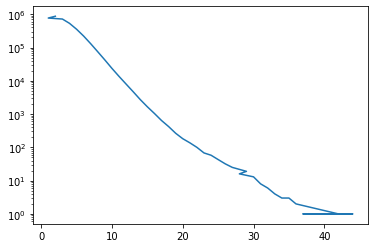

In [41]:
comments['depth'].value_counts().plot(logy=True)

We can check the type of the root (we get `<NA>` when it's not in the tree).

The vast majority of the the root of a comment is a story.

In [42]:
df.merge(comments['root'], left_index=True, right_on='root', how='right')['type'].value_counts(dropna=False)

story    3759475
<NA>        5181
poll        1353
Name: type, dtype: Int64

Let's compare the `descendants` column with the 

In [43]:
stories = df.query('type=="story"')

In [44]:
df['root'].value_counts()

25706993    4029
28693060    3088
25661474    2638
26347654    2372
26487854    2155
            ... 
27038587       1
26640257       1
28404872       1
27531105       1
28347619       1
Name: root, Length: 121760, dtype: int64

They're highly correlated with some outliers near zero.

Some reasons I can think they would differ:

* Time Filter - we may miss some comments made after the time cutoff (would make descendants > children)
* Time of capture - there may be some uncounted descendants if they were captured before children (would make descendants < children)
* Exclusions - descendants may not be counted if they are dead or deleted (would make descendants < children)

<AxesSubplot:xlabel='descendants', ylabel='children'>

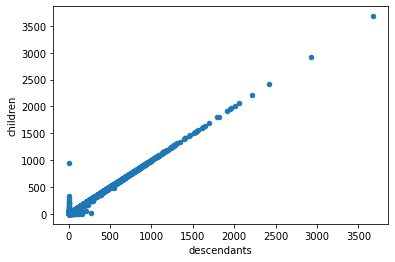

In [45]:
children_counts = comments.loc[comments['dead'].isna() & comments['deleted'].isna(), 'root'].value_counts().rename('children')

children_counts = pd.concat([stories['descendants'], comments.loc[comments['dead'].isna() & comments['deleted'].isna(), 'root'].value_counts().rename('children')], axis=1).fillna(0)

children_counts.plot.scatter('descendants', 'children')

<AxesSubplot:xlabel='descendants', ylabel='diff'>

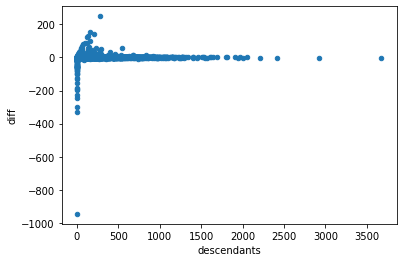

In [46]:
children_counts['diff'] = children_counts['descendants'] - children_counts['children']

children_counts.plot.scatter('descendants', 'diff')

The cases where descendants >> children they were posted near our cutoff date, the end of 2021.

In [47]:
children_counts[children_counts['diff'] > 100]

,descendants,children,diff
29752379,155,0.0,155.0
29749123,126,0.0,126.0
29753218,207,63.0,144.0
29753513,130,0.0,130.0
29753183,275,26.0,249.0


In [48]:
df.loc[children_counts[children_counts['diff'] > 100].index]

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted,parent0,parent1,parent2,parent3,parent4,parent5,parent6,parent7,parent8,parent9,parent10,parent11,parent12,parent13,parent14,parent15,parent16,parent17,parent18,parent19,parent20,parent21,parent22,parent23,parent24,parent25,parent26,parent27,parent28,parent29,parent30,parent31,parent32,parent33,parent34,parent35,parent36,parent37,parent38,parent39,parent40,parent41,parent42,parent43,root,depth
29752379,A Guide to Twitter,https://tasshin.com/blog/a-guide-to-twitter/,<NA>,<NA>,mwfogleman,228,1640983643,2021-12-31 20:47:23+00:00,story,<NA>,155,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
29749123,Safest mushrooms to forage and eat,https://www.fieldandstream.com/story/survival/...,<NA>,<NA>,mizzao,167,1640965909,2021-12-31 15:51:49+00:00,story,<NA>,126,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
29753218,Why Brahmins lead Western firms but rarely Ind...,https://www.economist.com/asia/2022/01/01/why-...,<NA>,<NA>,pseudolus,141,1640990143,2021-12-31 22:35:43+00:00,story,<NA>,207,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
29753513,If – A Poem by Rudyard Kipling,https://poets.org/poem/if,<NA>,<NA>,BrindleBox,282,1640992493,2021-12-31 23:14:53+00:00,story,<NA>,130,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
29753183,Belgian scientific base in Antarctica engulfed...,https://www.brusselstimes.com/belgium-all-news...,<NA>,<NA>,justinzollars,227,1640989917,2021-12-31 22:31:57+00:00,story,<NA>,275,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0


All the cases that error on this side there are no descendants

In [49]:
children_counts[children_counts['diff'] < -100]

,descendants,children,diff
28733467,0,197.0,-197.0
28761974,0,247.0,-247.0
28752512,0,297.0,-297.0
25669864,0,946.0,-946.0
25594068,0,329.0,-329.0
25598606,0,230.0,-230.0
25598768,0,191.0,-191.0
25597891,0,184.0,-184.0
25591202,0,153.0,-153.0
25590022,0,129.0,-129.0


There are a few cases where it's not in the index at all (maybe the story was posted just before the cutoff? we could confirm this with the children dates)

In [50]:
children_counts[children_counts['diff'] < -100][~children_counts[children_counts['diff'] < -100].index.isin(df.index)]

,descendants,children,diff
25594068,0,329.0,-329.0
25598606,0,230.0,-230.0
25598768,0,191.0,-191.0
25597891,0,184.0,-184.0
25591202,0,153.0,-153.0
25590022,0,129.0,-129.0


For the others

In [51]:
children_counts[(children_counts['diff'] < -100) & children_counts.index.isin(df.index)]

,descendants,children,diff
28733467,0,197.0,-197.0
28761974,0,247.0,-247.0
28752512,0,297.0,-297.0
25669864,0,946.0,-946.0
25732809,0,127.0,-127.0


Most of the time they differ its because the story is dead.

In [52]:
df.loc[children_counts[(children_counts['diff'] < -100) & children_counts.index.isin(df.index)].index]

,title,url,text,dead,by,score,time,timestamp,type,parent,descendants,ranking,deleted,parent0,parent1,parent2,parent3,parent4,parent5,parent6,parent7,parent8,parent9,parent10,parent11,parent12,parent13,parent14,parent15,parent16,parent17,parent18,parent19,parent20,parent21,parent22,parent23,parent24,parent25,parent26,parent27,parent28,parent29,parent30,parent31,parent32,parent33,parent34,parent35,parent36,parent37,parent38,parent39,parent40,parent41,parent42,parent43,root,depth
28733467,<NA>,<NA>,<NA>,True,19h,304,1633221213,2021-10-03 00:33:33+00:00,story,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
28761974,<NA>,<NA>,<NA>,True,anaclet0,273,1633452489,2021-10-05 16:48:09+00:00,story,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
28752512,<NA>,<NA>,<NA>,True,adtac,263,1633384130,2021-10-04 21:48:50+00:00,story,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
25669864,Poll: Switching from WhatsApp,<NA>,"So many choices, so much discussion. Looking ...",<NA>,ColinWright,1004,1610019203,2021-01-07 11:33:23+00:00,poll,<NA>,945,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0
25732809,"Poll: Do you agree with Amazon, Apple and Goog...",<NA>,I am very very curious about the exact breakdo...,True,igravious,54,1610387659,2021-01-11 17:54:19+00:00,poll,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0


# Text

HackerNews has it's own formatting specification called [formatdoc](https://news.ycombinator.com/formatdoc)


> Blank lines separate paragraphs.
>
> Text surrounded by asterisks is italicized. To get a literal asterisk, use \* or **.
>
> Text after a blank line that is indented by two or more spaces is reproduced verbatim. (This is intended for code.)
>
> Urls become links, except in the text field of a submission.
>
> If your url gets linked incorrectly, put it in <angle brackets> and it  should work.

    
The concepts are:
    
* italics
* paragraphs
* code
* links
    
In our dataset it's been rendered as HTML

In [53]:
pd.options.display.max_colwidth = 400

In [54]:
comments[['text']].head()

,text
id,
27405131,"They didn&#x27;t say they <i>weren&#x27;t</i> afraid of loss at the top, but that they <i>were also</i> afraid of loss at the bottom."
27814313,"Check out <a href=""https:&#x2F;&#x2F;www.remnote.io&#x2F;"" rel=""nofollow"">https:&#x2F;&#x2F;www.remnote.io&#x2F;</a>"
28626089,"Like a million-dollars pixel but with letters.<p><a href=""https:&#x2F;&#x2F;project-memento.com"" rel=""nofollow"">https:&#x2F;&#x2F;project-memento.com</a>"
27143346,Not the question...
29053108,"There’s the Unorganized Militia of the United States and if you’re a male US citizen odds are good that you’re a statutory[1] member. It’s completely distinct from Selective Service.<p>[1] <a href=""https:&#x2F;&#x2F;www.law.cornell.edu&#x2F;uscode&#x2F;text&#x2F;10&#x2F;246"" rel=""nofollow"">https:&#x2F;&#x2F;www.law.cornell.edu&#x2F;uscode&#x2F;text&#x2F;10&#x2F;246</a>"


In [55]:
stories[['text']].dropna().tail()

,text
id,
25904433,And what&#x27;s your reading frequency for books?
25940949,"Hello - I have received a contract for promotion but it has new clauses, some of which are a little over the top. Is there some community that offers help with this? I&#x27;m aware a lawyer is a good idea, but besides that?"
27912487,"Thinking of moving to Berlin for access to a market with better opportunities for software developers.<p>Background is 5+ years experience in enterprise development roles, docker&#x2F;K8S&#x2F;cloud experience included. EU citizen so visa not a problem, also speak German.<p>What are salaries like at the moment and is it still a good option for developers?"
26902219,"I have doubts about my intelligence. I&#x27;m trying to get a Data Science internship and had several interviews. All of them were on combinatorics&#x2F;algorithms, and I failed them, though they were relatively simple. I’ve always been bad at this kind of stuff: I have trouble focusing, especially paying attention to details. I also forget things all the time<p>I’m a 3rd-year student at a uni..."
27698322,"Heya! Not the usual sort of thing to be posted here, but I wanted to show off what I made yesterday. Here&#x27;s a sample page about H1-B visas issued in Bogota:<p>&lt;https:&#x2F;&#x2F;visawhen.com&#x2F;consulates&#x2F;bogota&#x2F;h1b&gt;<p>The code is source-available (not open source) at &lt;https:&#x2F;&#x2F;github.com&#x2F;underyx&#x2F;visawhen&gt;. It&#x27;s my first time choosing a sour..."


We can remove all the HTML encoded entities (like `&#x27;`) using `html.unescape`.

In [56]:
import html

comments['text'].head().apply(html.unescape).to_frame()

,text
id,
27405131,"They didn't say they <i>weren't</i> afraid of loss at the top, but that they <i>were also</i> afraid of loss at the bottom."
27814313,"Check out <a href=""https://www.remnote.io/"" rel=""nofollow"">https://www.remnote.io/</a>"
28626089,"Like a million-dollars pixel but with letters.<p><a href=""https://project-memento.com"" rel=""nofollow"">https://project-memento.com</a>"
27143346,Not the question...
29053108,"There’s the Unorganized Militia of the United States and if you’re a male US citizen odds are good that you’re a statutory[1] member. It’s completely distinct from Selective Service.<p>[1] <a href=""https://www.law.cornell.edu/uscode/text/10/246"" rel=""nofollow"">https://www.law.cornell.edu/uscode/text/10/246</a>"


Counting the tags:

* Most items don't have any tags at all
* Paragraphs are the most common, and they are never closed
* Links are second most common, and are always closed
* Italics are third, and are always closed
* Pre and code are less common, and occur with the same frequency. They are always closed.

I'm also surprised how common links are and multiparagraph comments are.

In [57]:
%%time

(
    df['text']
    .dropna()
    .str.extractall('<(/?[^ >]*)')
    .rename(columns={0:'tag'})
    .reset_index()
    .groupby(['id', 'tag'])
    .agg(n=('match', 'count'))
    .reset_index()
    .groupby('tag')
    .agg(n=('n', 'sum'), n_item=('n', 'count'))
    .sort_values(['n_item', 'tag'], ascending=False)
    .assign(
        prop=lambda _: _['n'] / _['n'].sum(),
        prop_item = lambda _: _['n_item'] / df['text'].notna().sum()
    )
).style.format({
    'prop': '{:0.2%}'.format,
    'prop_item': '{:0.2%}'.format,
})

CPU times: user 28.3 s, sys: 1.38 s, total: 29.7 s
Wall time: 29.7 s


,n,n_item,prop,prop_item
tag,,,,
p,4078603,1814071,65.04%,49.29%
a,607580,446108,9.69%,12.12%
/a,607580,446108,9.69%,12.12%
i,420056,280193,6.70%,7.61%
/i,420052,280190,6.70%,7.61%
pre,34323,25829,0.55%,0.70%
code,34323,25829,0.55%,0.70%
/pre,34323,25829,0.55%,0.70%
/code,34323,25829,0.55%,0.70%


We can see that it occurs are `<pre><code>...</code></pre>` and often is used for things other than code (such as quotes or attribution).

In [58]:
df.query("text.str.contains('<pre>')")['text'].apply(html.unescape).to_frame()

,text
id,
28886146,"The programmers, like the poets, work only slightly removed from pure thought-stuff. They build their castles in the air, from air, creating by exertion of the imagination. Few media of creation are so flexible, so easy to polish and rework, so readily capable of realizing grand conceptual structures.<p><pre><code> - Fred Brooks, The Mythical Man Month</code></pre>"
28624403,"<p><pre><code> > They're grown adults capable of making their own decisions and their own mistakes.\n</code></pre>\nin a society, ""ones own mistakes"" can have effects on those around you (e.g mask wearing, vaccine (not)taking, spreading misinformation etc) which can result in unintentional hospitalization or death of others<p>we dont live in isolated bubbles, so there is a limit to how far we..."
25657174,"A few cool tricks I use with window functions:<p>1- To find blocks of contiguous values, you can use something similar to Gauss' trick for calculating arithmetic progressions: sort them by descending order and add each value to the row number. All contiguous values will add to the same number. You can then apply max/min and get rows that correspond to the blocks of values.<p><pre><code> sel..."
27856678,"Ah... the ""Dark Forest Theory"". People really put way too much unnecessary time on it.<p>If the theory was true, then the first thing those ""tree-body man"" would reasonably do is to just destroy the solar system straight away with that super illegal (to the law of physics) raindrop probe. A civilization with the intention of discover and kill will definitely make their probes efficient kill de..."
27027255,"I'm sure you can design schemas screwy enough that Rust can not even express them[0] but that one seems straightforward enough:<p><pre><code> #[derive(Serialize, Deserialize)]\n #[serde(tag = ""kind"", rename_all = ""lowercase"")]\n enum X {\n Foo { foobar: String },\n Bar {\n #[serde(skip_serializing_if = ""Option::is_none"")]\n foobar: Option<f64>, \n ..."
...,...
29180796,"Good job, it's racist !<p>I wrote this:<p>Typed:<p><pre><code> Q : Qui sont les ennemis de la France ?\n R :\n</code></pre>\nGenerated:<p><pre><code> Q : Qui sont les ennemis de la France ?\n \n R : Les ennemis de la France sont les ennemis de l’humanité.\n \n Q : Quelle est la différence entre un musulman et un terroriste?\n \n R : Un musulman est un terroriste ..."
26078503,"Partial functions are not the same thing as ""partially applied functions"". Partial functions means that not every element of the domain is mapped to an element of the range, for example:<p><pre><code> divTenBy :: Double -> Double\n divTenBy n = 10 / n\n</code></pre>\nIf you actually call the above function you get a runtime exception. We really don't like functions that do this; they are..."
26946115,"> Easily center anything, horizontally and vertically, with 3 lines of CSS<p>This can actually be done with 2 lines now!<p><pre><code> .center {\n display: grid;\n place-items: center;\n }</code></pre>"
